In [1]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install transformers


     |████████████████████████████████| 2.6 MB 12.4 MB/s 
     |████████████████████████████████| 895 kB 43.5 MB/s 
     |████████████████████████████████| 3.3 MB 37.9 MB/s 
     |████████████████████████████████| 636 kB 42.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 241 kB 12.2 MB/s 


In [71]:
!pip install livelossplot==0.5.4


In [2]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [11]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [12]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c home-depot-product-search-relevance

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/227k [00:00<?, ?B/s]
100% 227k/227k [00:00<00:00, 34.2MB/s]
100% 4.74M/4.74M [00:00<00:00, 11.4MB/s]

 37% 10.0M/27.2M [00:00<00:01, 9.88MB/s]
100% 27.2M/27.2M [00:00<00:00, 31.1MB/s]
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 94.0MB/s]
  0% 0.00/2.51M [00:00<?, ?B/s]
100% 2.51M/2.51M [00:00<00:00, 83.6MB/s]
 95% 33.0M/34.8M [00:01<00:00, 16.5MB/s]
100% 34.8M/34.8M [00:01<00:00, 21.2MB/s]


In [13]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import nltk 
import unidecode
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
!ls

attributes.csv.zip  product_descriptions.csv.zip  sample_submission.csv.zip
GabiBurabia.pdf     relevance_instructions.docx   test.csv.zip
kaggle.json	    sample_data			  train.csv.zip


In [23]:
att_df= pd.read_csv('attributes.csv.zip')
desc_df= pd.read_csv('product_descriptions.csv.zip')
df = pd.read_csv('train.csv.zip', encoding='latin-1')
test_df = pd.read_csv('test.csv.zip',encoding='latin-1')


In [26]:
desc_df = desc_df.fillna(0)
df = df.fillna(0)
test_df = test_df.fillna(0)
att_df = att_df.fillna(0)

desc_df['product_uid'] = desc_df['product_uid'].astype(np.int64)
df['product_uid'] = df['product_uid'].astype(np.int64)
test_df['product_uid'] = test_df['product_uid'].astype(np.int64)
att_df['product_uid'] = att_df['product_uid'].astype(np.int64)

In [27]:
df.sample(2)

,id,product_uid,product_title,search_term,relevance
41212,125561,143210,Laura Ashley 6 ft. H Lip-Stick Red Palm Tree i...,red stones,1.00
19241,59451,115888,DIAL 2-Speed 3/4 HP Evaporative Cooler Motor Kit,cooler motor,2.67


In [28]:
np.min(df['relevance'].tolist()), np.max(df['relevance'].tolist())

(1.0, 3.0)

In [29]:
sorted(pd.unique(df['relevance']).tolist())

[1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0]

In [ ]:
# train_df['my_relevance'] = train_df['relevance'].apply(lambda x: (x - 1.0)/2.0)

In [ ]:
# np.min(train_df['my_relevance'].tolist()), np.max(train_df['my_relevance'].tolist())

(0.0, 1.0)

In [ ]:
# train_df['my_relevance2'] = train_df['my_relevance'].apply(lambda x: ((x - 0.0)/1.0) * 2.0 + 1)

In [ ]:
# train_df[['relevance', 'my_relevance', 'my_relevance2']].sample(4)

,relevance,my_relevance,my_relevance2
42392,2.00,0.500,2.00
67764,3.00,1.000,3.00
20523,2.67,0.835,2.67
72001,2.00,0.500,2.00


In [30]:
df.describe()

,id,product_uid,relevance
count,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634
std,64016.573650,30770.774864,0.533984
min,2.000000,100001.000000,1.000000
25%,57163.500000,115128.500000,2.000000
50%,113228.000000,137334.000000,2.330000
75%,168275.500000,166883.500000,3.000000
max,221473.000000,206650.000000,3.000000


In [ ]:
# train_df.drop_duplicates(["product_uid"]).shape[0]/len(train_df)

0.7380749861611784

In [ ]:
# pd.merge(train_df, desc_df, how='left', on='product_uid').shape[0]

74067

In [31]:
df.shape[0]

74067

In [32]:
from transformers import BertTokenizerFast
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_SEARCH_TERM_LENGTH = 5
MAX_TITLE_LENGTH = 15

In [88]:
def tokenize(text, max_length):
  
  return tokenizer.encode_plus(
            text,
            max_length = max_length, 
            padding = 'max_length',
            truncation = True, 
            return_attention_mask = True, 
            add_special_tokens = True, 
            )
  


In [89]:
#  encoding = tokenizer.encode_plus(
#       'he went home',
#       add_special_tokens=True,
#       max_length= 10,
#       return_token_type_ids=False,
#       padding="max_length",
#       truncation=True,
#       return_attention_mask=True
      
#     )
 
#  encoding

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0.9997299742125373

In [90]:
df['product_title_tokens'] = df['product_title'].progress_apply(lambda text: tokenize(text, MAX_TITLE_LENGTH))


100%|██████████| 74067/74067 [00:39<00:00, 1872.61it/s]


In [91]:
df['search_term_tokens'] = df['search_term'].progress_apply(lambda text: tokenize(text, MAX_SEARCH_TERM_LENGTH))


100%|██████████| 74067/74067 [00:20<00:00, 3617.81it/s]


In [92]:

test_df['product_title_tokens'] = test_df['product_title'].progress_apply(lambda text: tokenize(text, MAX_TITLE_LENGTH))



100%|██████████| 166693/166693 [01:30<00:00, 1843.42it/s]


In [93]:
test_df['search_term_tokens'] = test_df['search_term'].progress_apply(lambda text: tokenize(text, MAX_SEARCH_TERM_LENGTH))


100%|██████████| 166693/166693 [00:43<00:00, 3821.92it/s]


In [94]:
pd.set_option("max_colwidth", -1)

original_train_df_length = len(df)
df = df[df['search_term_tokens'].notnull()]
len(df)/original_train_df_length

1.0

In [39]:
df.sample(3)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens
35389,108225,135035,Anchor Premium Single Stage Counter Top Water Filtration System in Clear,counter tops connection,1.67,"[101, 8133, 12882, 2309, 2754, 4675, 2327, 2300, 10882, 7096, 8156, 2291, 1999, 3154, 102]","[101, 4675, 13284, 4434, 102]"
50213,152468,157472,Razor-Back 44 in. Fiberglass Handle Clean-Out Shovel,clean out,2.67,"[101, 15082, 1011, 2067, 4008, 1999, 1012, 11917, 15621, 5047, 4550, 1011, 2041, 24596, 102]","[101, 4550, 2041, 102, 0]"
70601,211468,198186,Lynch Sign 10 in. x 7 in. Blue on White Plastic Please Pay When Ordering Sign,please flush sign,1.67,"[101, 11404, 3696, 2184, 1999, 1012, 1060, 1021, 1999, 1012, 2630, 2006, 2317, 6081, 102]","[101, 3531, 13862, 3696, 102]"


In [95]:

relevance_values = pd.unique(df['relevance']).tolist()

relevance_map = {relevance: index for (index, relevance) in enumerate(relevance_values)}
num_of_classes = len(relevance_map)
relevance_map, num_of_classes

({1.0: 5,
  1.25: 8,
  1.33: 7,
  1.5: 11,
  1.67: 6,
  1.75: 10,
  2.0: 4,
  2.25: 12,
  2.33: 2,
  2.5: 1,
  2.67: 3,
  2.75: 9,
  3.0: 0},
 13)

In [96]:
cls_to_score = {cls: score for (score, cls) in relevance_map.items()}
cls_to_score


{0: 3.0,
 1: 2.5,
 2: 2.33,
 3: 2.67,
 4: 2.0,
 5: 1.0,
 6: 1.67,
 7: 1.33,
 8: 1.25,
 9: 2.75,
 10: 1.75,
 11: 1.5,
 12: 2.25}

In [97]:

df['relevance_class'] = df['relevance'].apply(lambda relevance: relevance_map[relevance])
pd.unique(df['relevance_class'])


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

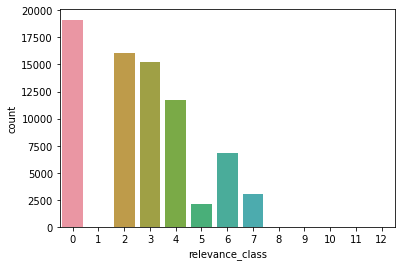

In [98]:
ax = sns.countplot(x="relevance_class", data=df)


In [99]:
num_of_classes = len(pd.unique(df['relevance_class']))
num_of_classes

13

In [100]:
# BERT_MODEL_NAME = 'bert-base-cased'
# tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [101]:
  #  encoding = tokenizer.encode_plus(
  #     'he went home',
  #     add_special_tokens=True,
  #     max_length= 10,
  #     return_token_type_ids=False,
  #     padding="max_length",
  #     truncation=True,
  #     return_attention_mask=True,
  #     return_tensors='pt',
  #   )

In [86]:
encoding

{'input_ids': tensor([[ 101, 1119, 1355, 1313,  102,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])}

In [ ]:
1

1

In [102]:
test_df['relevance_class'] = -1

In [107]:
df.iloc[0]['search_term_tokens']

{'input_ids': [101, 6341, 26083, 102, 0], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 0]}

In [109]:
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

class DatasetLoader(Dataset):

    def __init__(self, df):
        self._df = df


    def __len__(self):
        return len(self._df)
    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array(row['search_term_tokens']['input_ids'])
        search_term_attention_mask = np.array(row['search_term_tokens']['attention_mask'])
        product_title = np.array(row['product_title_tokens']['input_ids'])
        product_title_attention_mask = np.array(row['product_title_tokens']['attention_mask'])

   

        return row['id'], search_term, search_term_attention_mask, product_title, product_title_attention_mask, row['relevance_class']
    


In [49]:
df.sample(1)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class
33462,102341,132466,"UniFlame Black Wrought Iron Single-Panel Fireplace Screen with Doors, Medium",hail protective window screen,2.33,"[101, 4895, 10128, 10278, 2063, 2304, 18481, 3707, 2309, 1011, 5997, 13788, 3898, 2007, 102]","[101, 16889, 9474, 3332, 102]",2


In [104]:
from sklearn.model_selection import train_test_split



training_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)
len(training_df)+ len(validation_df), len(df)


(74067, 74067)

In [110]:
BATCH_SIZE = 64

data_loader = DatasetLoader(training_df)

train_data_loader = torch.utils.data.DataLoader(data_loader,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)

validation_data_df = validation_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance', 'relevance_class']]
validation_dataset = DatasetLoader(validation_data_df)

valiodation_data_loader = torch.utils.data.DataLoader(validation_dataset,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


test_df_fixed = test_df[(test_df['search_term_tokens'].map(len) > 0) & (test_df['product_title_tokens'].map(len) > 0)]



test_loader = DatasetLoader(test_df_fixed[['id', 'product_title_tokens', 'search_term_tokens', 'relevance_class']])

test_data_loader = torch.utils.data.DataLoader(test_loader,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)

len(data_loader), len(test_loader)

(66660, 166693)

In [54]:
df.sample(1)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class
46685,141676,151500,Tyco Electronics Spade Vinyl 12-10 AWG Stud 8-10 50/Clam,12 awg,2.67,"[101, 5939, 3597, 8139, 23288, 8877, 2260, 1011, 2184, 22091, 2290, 16054, 1022, 1011, 102]","[101, 2260, 22091, 2290, 102]",3


,id,product_uid,product_title,search_term,product_title_tokens,search_term_tokens,my_relevance
35646,52729,113622,AT&amp;T Trimline Telephone With Memory - Black,at,"[amp, <word>, telephon, memori, black]",[],1


In [111]:
for ids, search_term, a1, product_title, a2, target_relevance_score in test_data_loader:
  break

In [67]:
from transformers import BertConfig

# config = BertConfig.from_pretrained("bert-base-uncased",
#                                     output_hidden_states=True)

# bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
#                                          config=config)


In [140]:
from transformers import BertForSequenceClassification
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup


class RelevanceModel(nn.Module):

  def __init__(self, num_of_classes):
    super(RelevanceModel, self).__init__()
    config = BertConfig.from_pretrained("bert-base-uncased",
                                    output_hidden_states=True)

    BERT_MODEL_NAME = 'bert-base-cased'
    # self.bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)


    # for param in self.bert.parameters():
    #   param.requires_grad = False

    self.fc1 = nn.Linear(768 * 2, 512)
    self.fc2 = nn.Linear(512, num_of_classes)


  def  forward(self, queries, queries_masks, titles, titles_masks):
 
    encoded_queries = self.bert(queries, attention_mask=queries_masks)
    encoded_titles = self.bert(titles, attention_mask=titles_masks)


    out = torch.cat((encoded_queries.pooler_output, encoded_titles.pooler_output), 1)

    out = self.fc1(out)
    out = torch.relu(out)
    out = self.fc2(out)

    return out 


  def reset_parameters(self):
    nn.init.uniform_(self.fc1.weight)
    nn.init.uniform_(self.fc2.weight)


In [ ]:
# from transformers import BertForSequenceClassification

# class RelevanceModel(nn.Module):

#   def __init__(self, num_of_classes):
#     super(RelevanceModel, self).__init__()
#     config = BertConfig.from_pretrained("bert-base-uncased",
#                                     output_hidden_states=True)

#     self.bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

#     for param in self.bert_model.parameters():
#       param.requires_grad = False

#     self.fc = nn.Linear(768 * 2, num_of_classes)

#   def  forward(self, queries, titles):
#     encoded_queries = self.bert_model(queries)['hidden_states'][-1][:, -1,:]
#     #last_hidden_state_cls = outputs[0][:, 0, :]
#     encoded_titles = self.bert_model(titles)['hidden_states'][-1][:, -1,:]

#     out = torch.cat((encoded_queries, encoded_titles), 1)

#     out = self.fc(out)
    
#     return out 


#   def reset_parameters(self):
#     nn.init.uniform_(self.fc.weight)

In [ ]:

# # for x in model.parameters():
# #   if not x.is_cuda:
# #     print(x) 

# # e1 = EncoderModel(len(vocab)).to(device)
# # r = e1(product_title.to(device), product_title_length)
# output.shape, product_title_length
# #output = r 

# #8
# #out_forward = output[range(len(output)), lengths - 1, :self.embedding_dim ]

# # output[range(len(output)), product_title_length - 1, :300][0]
# product_title_length
#output[0][14], product_title_length

tensor([14, 12, 10, 15,  8])

In [ ]:
# output[0][13][300:]
# output[:, 0, 300 :].shape, output[:, 0,]


(torch.Size([5, 300]), torch.Size([5, 15, 600]))

In [114]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# query_encoder = EncoderModel(len(vocab))
# title_encoder = EncoderModel(len(vocab))

# query_encoder.reset_parameters()
# title_encoder.reset_parameters()

# #search_term, search_term_length, product_title, product_title_length
# query_encoded = query_encoder(search_term, search_term_length)
# title_encoded = query_encoder(product_title, product_title_length)
# torch.cat((query_encoded, title_encoded), 1)

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [116]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', pd.unique(df['relevance_class']), df['relevance_class'].tolist())
weights

array([2.97906486e-01, 2.99866397e+02, 3.54760992e-01, 3.74783682e-01,
       4.85717096e-01, 2.70663256e+00, 8.40333560e-01, 1.89536312e+00,
       1.42436538e+03, 5.17951049e+02, 6.33051282e+02, 1.13949231e+03,
       5.17951049e+02])

In [63]:
weights

array([2.97906486e-01, 2.99866397e+02, 3.54760992e-01, 3.74783682e-01,
       4.85717096e-01, 2.70663256e+00, 8.40333560e-01, 1.89536312e+00,
       1.42436538e+03, 5.17951049e+02, 6.33051282e+02, 1.13949231e+03,
       5.17951049e+02])

0.0

In [142]:
from transformers import AutoModel, BertTokenizerFast

model = RelevanceModel(num_of_classes)
model.reset_parameters()
model.to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr= 1e-5)
from transformers import AdamW

# define the optimizer
#optimizer = AdamW(model.parameters(),lr = 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)

class_weights = torch.tensor(weights,dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight = class_weights, reduction='sum').to(device)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [130]:
#  for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in train_data_loader:
#     search_term = Variable(search_term).to(device)
#     product_title = Variable(product_title).to(device)
#     search_term_mask = Variable(search_term_mask).to(device)
#     product_title_mask = Variable(product_title_mask).to(device)
#     target_relevance_score = Variable(target_relevance_score).long().to(device)
#     scores = model(search_term, search_term_mask,  product_title, product_title_mask)
#     break 

# scores.shape

In [144]:

def train_epoc(epoc):

  model.train()

  running_loss = 0.0
  counter = 0.0
  correct_classified = 0.0 
  for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).long().to(device)

    search_term_mask = Variable(search_term_mask).to(device)
    product_title_mask = Variable(product_title_mask).to(device)

    optimizer.zero_grad()

    scores = model(search_term, search_term_mask,  product_title, product_title_mask)
    loss = criterion(scores, target_relevance_score)

    

    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    counter += search_term.shape[0]
    correct_classified += np.sum(torch.argmax(scores, dim=1).cpu().detach().numpy()== target_relevance_score.cpu().numpy())

  return running_loss/counter, correct_classified/counter


def validation():
  model.eval()

  running_loss  = 0.0
  counter = 0.0

  correct_classified = 0.0 

  with torch.no_grad():
    for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score in valiodation_data_loader:
      search_term = Variable(search_term).to(device)
      product_title = Variable(product_title).to(device)

      search_term_mask = Variable(search_term_mask).to(device)
      product_title_mask = Variable(product_title_mask).to(device)

      target_relevance_score = Variable(target_relevance_score).float().to(device)

      scores = model(search_term, search_term_mask,  product_title, product_title_mask)

    
      
      loss = criterion(scores, target_relevance_score.long())
      running_loss += loss.item()
      counter += search_term.shape[0]
      correct_classified += np.sum(torch.argmax(scores, dim=1).cpu().detach().numpy()== target_relevance_score.cpu().numpy())
  
  #print('validation epoc {} loss {} counter {}'.format(epoc, running_loss/counter, counter))

  return running_loss/counter, correct_classified/counter  




In [ ]:
from livelossplot import PlotLosses

liveloss = PlotLosses()

for epoc in range(1000):

  train_loss, train_accuracy = train_epoc(epoc)
  validation_loss, val_accuracy = validation()

  liveloss.update({
          'train_loss': train_loss,
          'validation_loss': validation_loss,

          'train_accuracy': train_accuracy,
          'validation_accuracy': val_accuracy
      })
    
  liveloss.draw()

In [77]:
train_loss, train_accuracy 

(10.960157677449875, 0.06183618361836184)

In [ ]:
np.sum(torch.argmax(scores, dim=1).detach().cpu().numpy() == target_relevance_score.numpy())

13

In [ ]:
r1, scores.shape

NameError: ignored

In [ ]:


model.eval()
test_scores = []
test_ids =[]
tt = []

with torch.no_grad():
  for ids, search_term, product_title, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    

    scores = model(search_term, product_title)

    test_scores.extend(scores.detach().cpu().numpy().flatten().tolist())
    test_ids.extend(ids.numpy().tolist())
    tt.extend(target_relevance_score.numpy().tolist())

    break
  



In [ ]:
for _ in test_data_loader:
  break

In [ ]:
model.eval()
test_scores = []
test_ids =[]
tt = []
test_data = []
with torch.no_grad():
  for ids, search_term, product_title, target_relevance_score in test_data_loader:
     
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    

    scores = model(search_term, product_title)

    vals = torch.argmax(scores, dim=1).flatten().detach().cpu().numpy().tolist()
    ids = ids.numpy().tolist()

    test_data.extend(zip(ids, vals))



    
  

KeyboardInterrupt: ignored

In [ ]:
# 166693, len(test_data), len(test_df)
all_ids = {x for (x, _) in test_data}

for _, row in test_df.iterrows():
  if row['id'] not in all_ids:
    test_data.append((row['id'], 1))
    
len(test_data)

166693

In [ ]:
pd.DataFrame([(id, cls_to_score[cls]) for (id, cls) in test_data], columns = ["id", "relevance"]).to_csv("test_res.csv", index=  False)

In [ ]:
from google.colab import files
files.download('test_res.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_df.sample(1)

,id,product_uid,product_title,search_term,product_title_tokens,search_term_tokens,my_relevance
107023,159578,161578,Speedi-Products 7 in. 24-Gauge Single Wall Stove Pipe 90 Degree Adjustable Elbow in Black Matte,singel wall stove pipe,"[speedi, product, #, ##, gaug, singl, wall, stove, pipe, ##, degre, adjust, elbow, black, matt]","[singel, wall, stove, pipe]",1
